# Exploratory Data Analysis

## Set up

In [4]:
%matplotlib inline

import itertools
import logging
import pickle
import folium
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn import preprocessing
from datetime import datetime, date, timedelta
from palettable.colorbrewer.sequential import Oranges_9

from src.data.visualization import create_london_map, draw_stations_map

sns.set_context("notebook")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [5]:
readings = pickle.load(open("data/parsed/readings_weather_dataset_final.p", "rb"))
stations = pickle.load(open('data/parsed/stations_dataset_final.p', 'rb'))
distributed = pickle.load(open('data/parsed/distributed_dataset_final.p', 'rb'))
collected = pickle.load(open('data/parsed/collected_dataset_final.p', 'rb'))

In [76]:
def get_day_start_end(day, hours=None):
    start = day.replace(hour=7, minute=0, second=0, microsecond=0)
    if hours is None:
        return (start, day.replace(hour=23, minute=0, second=0, microsecond=0))
    else:
        return (start, start + timedelta(hours=hours))
    
def get_full_day_range(timestamp):
    return timestamp.replace(hour=0, minute=0, second=0, microsecond=0), timestamp.replace(hour=23, minute=59, second=59, microsecond=999)

def filter_by_time(df, d1, d2):
    timestamp = df['Timestamp']
    selector = (timestamp >= d1) & (timestamp < d2)
    return df[selector]
    
def filter_by_id(df, idval):
    return df[df['Id'] == idval]

global_start = datetime(2016,5,16)
global_end = datetime(2016,6,26)

## Station Priority

In [4]:
def map_priority_color(priority):
    if priority == 1:
        return '#ff1a1a', '#cc0000'
    elif priority == 2:
        return '#3333ff', '#0000cc'
    else: 
        return '#ffff1a', '#b3b300'
    
def create_priority_marker(station):
    colors = map_priority_color(station['Priority'])
    label = "%s - %s" % (station['Id'], station['Name'])

    return folium.CircleMarker(location=[station['Latitude'], station['Longitude']], radius=50,
                        popup=label, color=colors[1], fill_color=colors[0])

priority_map = draw_stations_map(stations, create_priority_marker)

folium.Map.save(priority_map, 'reports/maps/stations_priorities.html')

## Bicycle Availability Readings

### Why are the readings not continuous?

We believe the readings are updated as follows:
* The station publishes its readings only when an change in the station occurred in the last 5 minutes
* This means most of the readings will be different than the previous one
* When this is not the case, we suspect that an equal number of bikes left and arrived to the station, leaving the station in the same state as it was before but triggering an update to be published

In [5]:
start, end = get_day_start_end(datetime(2016,5,17))
df = filter_by_time(filter_by_id(readings, 'BikePoints_374'), start, end)[['Timestamp', 'NbBikes']]
df

,Timestamp,NbBikes
42974,2016-05-17 07:01:32.630,28
43296,2016-05-17 07:06:32.950,21
43997,2016-05-17 07:16:34.417,0
44476,2016-05-17 07:26:35.743,2
44799,2016-05-17 07:31:37.263,0
45061,2016-05-17 07:36:37.580,3
45445,2016-05-17 07:41:37.047,5
45861,2016-05-17 07:46:41.207,7
46201,2016-05-17 07:51:40.080,2
46733,2016-05-17 08:01:41.860,1


### When are the stations full or empty?

In [6]:
import uuid

def find_next(df, start_loc, col_name):
    if start_loc + 1 == len(df):
        return None
    else:    
        return df.loc[start_loc + 1]

def find_zero_periods_of(station_id, df, col_name):
    df = filter_by_id(df, station_id).copy().reset_index()

    entries = []
    for idx in df[df[col_name] == 0].index:
        next_reading = find_next(df, idx, col_name)
        if next_reading is None:
            continue
            
        start, end = df.loc[idx]['Timestamp'], next_reading['Timestamp']        
        
        periodId = uuid.uuid4()
        # create entry
        entries.append({
            'Id': station_id,
            'Timestamp': start,
            'PeriodId': periodId
        })
        
        entries.append({
            'Id': station_id,
            'Timestamp': end,
            'PeriodId': periodId
        })
        
    return entries

def find_zero_periods(df, col_name):
    periods = []
    [periods.append(find_zero_periods_of(station_id, df, col_name)) for station_id in df['Id'].unique()]
    return pd.DataFrame(list(itertools.chain.from_iterable(periods))) 

def group_ellapsed(df):
    ellapsed = lambda x: np.round((x[1] - x[0]) / pd.np.timedelta64(1, 'm'))
    
    collapsed = df.groupby(['Id', 'PeriodId']).aggregate(lambda x: tuple(x))
    collapsed['Ellapsed'] = collapsed['Timestamp'].apply(ellapsed)
    collapsed.reset_index(level=0, inplace=True)
    collapsed.reset_index(level=0, inplace=True)
    
    return collapsed

def add_station_info(df):
    df_stations = df.merge(stations, on='Id', how='inner')
    df_stations.drop(['TerminalName','PlaceType','Installed','Temporary','Locked','RemovalDate','InstallDate','ShortName'], axis=1, inplace=True)
    return df_stations

In [7]:
import uuid

def find_next(df, start_loc, col_name):
    if start_loc + 1 == len(df):
        return None
    else:    
        return df.loc[start_loc + 1]
    
def get_ranges(start, end):
    if (end.date() - start.date()).days > 0:
        return True, start.replace(hour=23, minute=59, second=59), (start + timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    else:
        return False, end, None

def find_zero_periods_of(station_id, df, col_name):
    df = filter_by_id(df, station_id).copy().reset_index()

    entries = []
    for idx in df[df[col_name] == 0].index:
        next_reading = find_next(df, idx, col_name)
        if next_reading is None:
            continue
            
        start, end = df.loc[idx]['Timestamp'], next_reading['Timestamp']                
        periodId = uuid.uuid4()
        
        distinct_days = True
        while distinct_days:
            distinct_days, current_end, next_start = get_ranges(start, end)
            
            # create entries
            entries.append({
                'Id': station_id,
                'Timestamp': start,
                'PeriodId': periodId
            })
        
            entries.append({
                'Id': station_id,
                'Timestamp': current_end,
                'PeriodId': periodId
            })
            
            start = next_start        
        
    return entries

def find_zero_periods(df, col_name):
    periods = []
    [periods.append(find_zero_periods_of(station_id, df, col_name)) for station_id in df['Id'].unique()]
    return pd.DataFrame(list(itertools.chain.from_iterable(periods))) 

def group_ellapsed(df):
    ellapsed = lambda x: np.round((x[-1] - x[0]) / pd.np.timedelta64(1, 'm'))
    
    collapsed = df.groupby(['Id', 'PeriodId']).aggregate(lambda x: tuple(x))
    collapsed['Ellapsed'] = collapsed['Timestamp'].apply(ellapsed)
    collapsed.reset_index(level=0, inplace=True)
    collapsed.reset_index(level=0, inplace=True)
    
    return collapsed

def add_station_info(df):
    df_stations = df.merge(stations, on='Id', how='inner')
    df_stations.drop(['TerminalName','PlaceType','Installed','Temporary','Locked','RemovalDate','InstallDate','ShortName'], axis=1, inplace=True)
    return df_stations

#### Empty

In [8]:
empty = find_zero_periods(readings, 'NbBikes')
empty.head()

,Id,PeriodId,Timestamp
0,BikePoints_359,d21a58be-c88f-4b36-a09d-21abced55fca,2016-05-16 17:16:40.373
1,BikePoints_359,d21a58be-c88f-4b36-a09d-21abced55fca,2016-05-16 18:06:46.650
2,BikePoints_359,e0ba9aa5-40d4-4106-bbdb-20cd7ff0aec9,2016-05-16 20:13:09.770
3,BikePoints_359,e0ba9aa5-40d4-4106-bbdb-20cd7ff0aec9,2016-05-16 23:59:59.770
4,BikePoints_359,e0ba9aa5-40d4-4106-bbdb-20cd7ff0aec9,2016-05-17 00:00:00.000


In [9]:
group_ellapsed(empty).sort_values(by=['Ellapsed'], ascending=False)

,PeriodId,Id,Timestamp,Ellapsed
52445,4269c619-b26c-44a4-9e83-ceba30c6d05a,BikePoints_86,"(2016-05-27 12:57:50.593000, 2016-05-27 23:59:...",20420.0
49347,30dcbb8f-570a-4cfa-8924-1171b87d9285,BikePoints_742,"(2016-05-24 20:37:37.840000, 2016-05-24 23:59:...",18466.0
51391,9c0ead25-7bd0-4758-8f93-fbe57d8a875a,BikePoints_791,"(2016-06-03 12:36:28.897000, 2016-06-03 23:59:...",16096.0
51393,ce0b799b-8068-44f7-ae3f-43119eb26f51,BikePoints_791,"(2016-05-20 10:40:04.140000, 2016-05-20 23:59:...",15980.0
52111,bbc77049-24cb-425e-8211-c5413109366a,BikePoints_817,"(2016-06-03 11:27:24.940000, 2016-06-03 23:59:...",14525.0
52101,e7aca52a-b89a-43b9-ab64-10af854be507,BikePoints_811,"(2016-06-16 10:02:29.067000, 2016-06-16 23:59:...",10060.0
51394,dd14923d-e1b5-4472-b093-4128e9cb247f,BikePoints_791,"(2016-06-14 16:52:03.870000, 2016-06-14 23:59:...",9995.0
52103,1e457575-dd56-4499-8513-2f96b064f97c,BikePoints_814,"(2016-05-26 14:14:24.093000, 2016-05-26 23:59:...",9974.0
51717,7f815c03-b3c1-449e-bbec-952ba4e888f7,BikePoints_802,"(2016-05-26 13:19:17.907000, 2016-05-26 23:59:...",9948.0
51432,22545045-7966-4104-a6be-e84039249bf0,BikePoints_793,"(2016-05-31 12:44:52.437000, 2016-05-31 23:59:...",9772.0


In [10]:
top_empty = group_ellapsed(empty).groupby('Id').sum().sort_values(by=['Ellapsed'], ascending=False).reset_index()
top_empty.head()

,Id,Ellapsed
0,BikePoints_791,50490.0
1,BikePoints_373,27353.0
2,BikePoints_120,27056.0
3,BikePoints_127,25303.0
4,BikePoints_106,25111.0


In [11]:
from matplotlib.ticker import FuncFormatter

def epoch_to_string(x, pos):
    timestamp = datetime.fromtimestamp(x)
    return timestamp.strftime("%H:%M")

formatter = FuncFormatter(epoch_to_string)

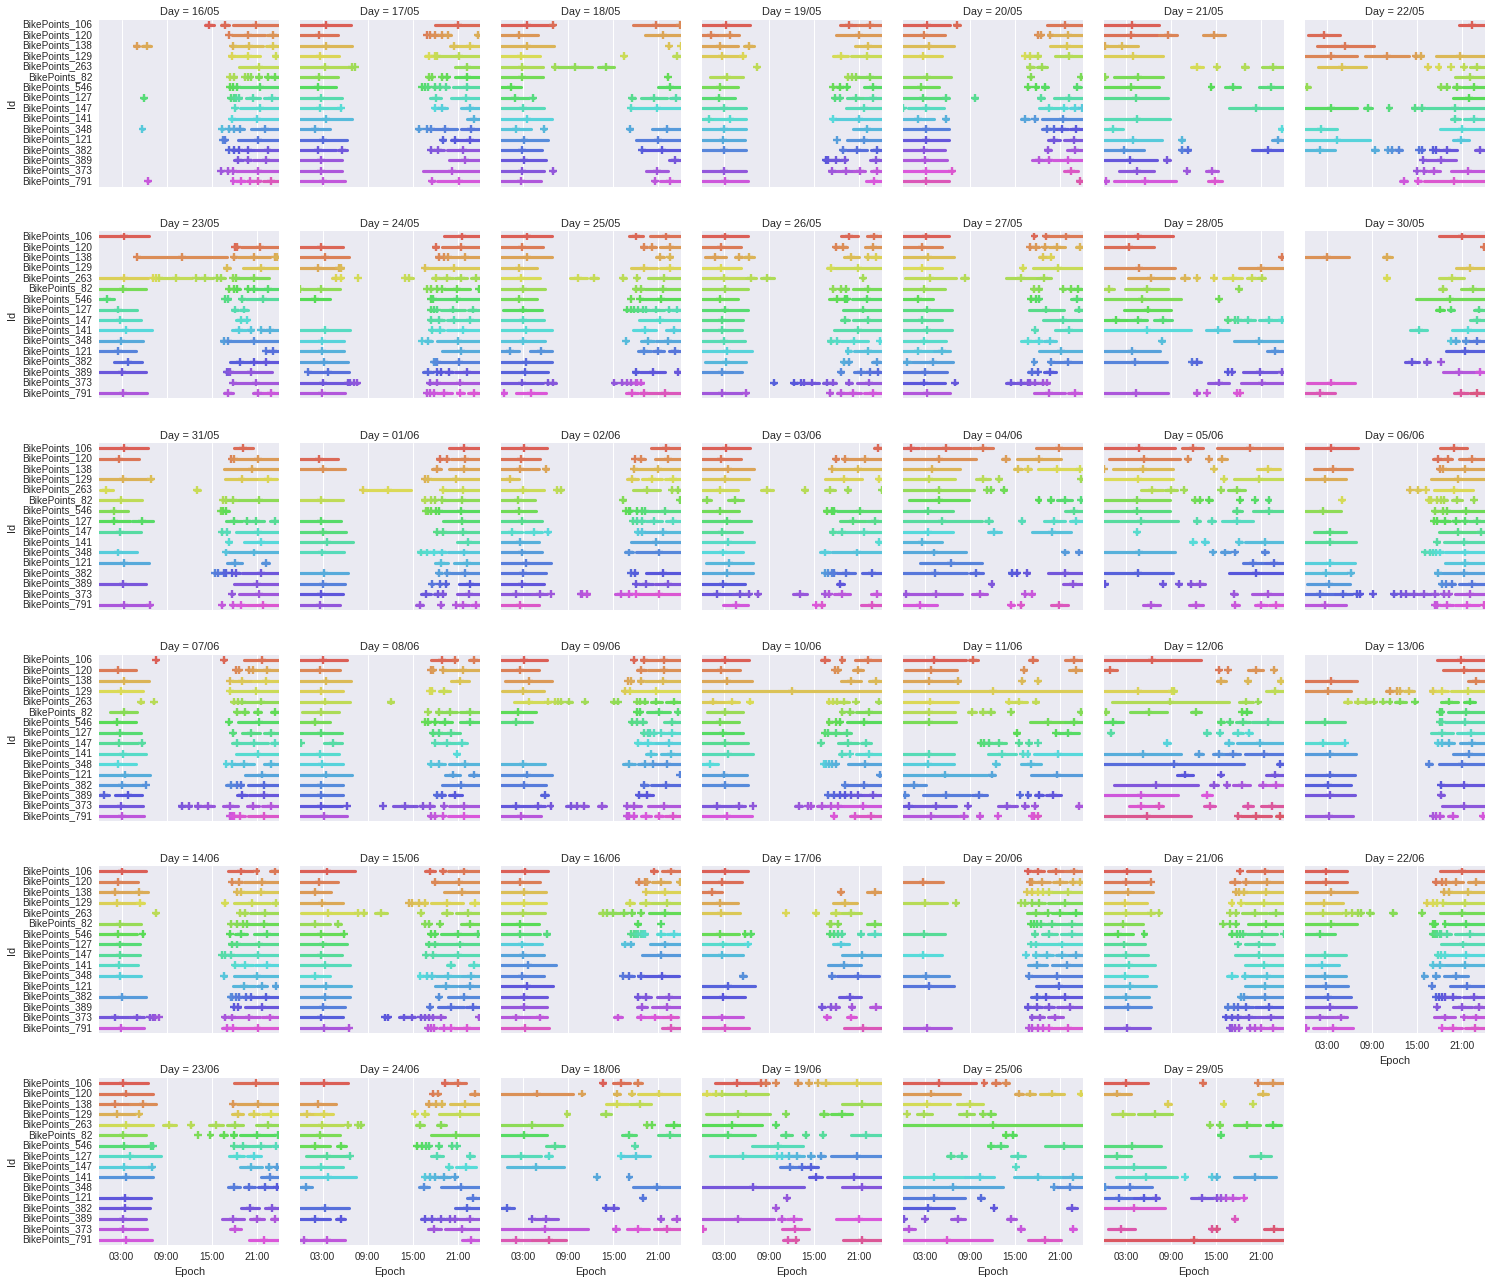

In [104]:
def plot(df, start, end, ids=None):
    df = df[df['Id'].isin(ids)]
    df = filter_by_time(df, start, end).copy()
    df['Day'] = df['Timestamp'].apply(lambda x: x.strftime("%d/%m"))
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=1970, month=1, day=1))
    df['Epoch'] = df['Timestamp'].apply(lambda x: long(x.strftime('%s')))
                
    day_start, day_end = get_full_day_range(df.iloc[0]['Timestamp'])
    g = sns.FacetGrid(df, col="Day", col_wrap=7, size=3, xlim=(-3600, 82799), sharey=True)
    g = g.map(sns.pointplot, "Epoch", "Id", "PeriodId", palette="hls", join=False, markers='+', col_order=ids)
    g = g.set(xticks=[7200, 28800, 50400, 72000])
    [ax.xaxis.set_major_formatter(formatter) for ax in g.axes]
    return g

plot(empty, datetime(2016,5,16), datetime(2016,6,26), top_empty['Id'][0:20])

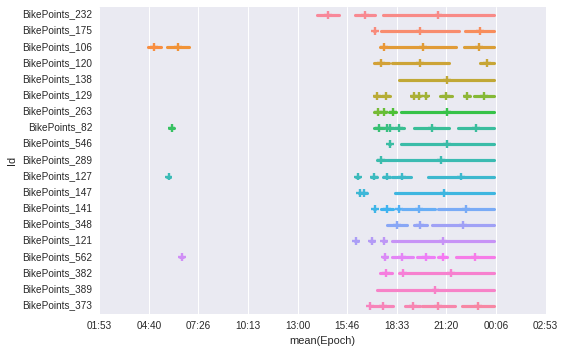

In [12]:
emptysub = filter_by_time(empty, datetime(2016,5,16), datetime(2016,5,17))
emptysub = emptysub[emptysub['Id'].isin(top_empty['Id'][0:20])]
emptysub['Epoch'] = emptysub['Timestamp'].apply(lambda x: long(x.strftime('%s')))
ax = sns.pointplot(x="Epoch", y="Id", hue="PeriodId", data=emptysub, join=False, markers='+')
ax.legend_.remove()
ax.xaxis.set_major_formatter(formatter)

#### Full

In [14]:
full = find_zero_periods(readings, 'NbEmptyDocks')
full.head()

,Id,PeriodId,Timestamp
0,BikePoints_482,f3a712c7-b8b8-42d5-812c-039b52cc18ba,2016-05-23 13:37:42.937
1,BikePoints_482,f3a712c7-b8b8-42d5-812c-039b52cc18ba,2016-05-23 13:38:08.427
2,BikePoints_482,b49459ed-3f84-449b-8b6c-7ca489ba0b19,2016-05-23 13:38:08.427
3,BikePoints_482,b49459ed-3f84-449b-8b6c-7ca489ba0b19,2016-05-23 14:42:51.293
4,BikePoints_482,09c7c78a-c9bc-4b26-b0d9-b7b1aa2ba067,2016-05-23 19:49:00.007


In [15]:
top_full = group_ellapsed(full).groupby('Id').sum().sort_values(by=['Ellapsed'], ascending=False)
top_full.head()

,Ellapsed
Id,
BikePoints_791,50490.0
BikePoints_742,24081.0
BikePoints_86,23086.0
BikePoints_672,20842.0
BikePoints_818,19939.0


### High vs Low Priority

In [16]:
def plot_station_readings(readings, station_id, ycols1, ycols2, d1, d2):
    date_range = pd.date_range(d1, d2, freq='d')
    date_pairs = [[date_range[i], date_range[i+1]] for i in range(len(date_range)-1)]

    station_readings = filter_by_id(readings, station_id)
    slices = slice_by(station_readings, 'Timestamp', date_pairs)  
    
    # set plot properties
    ncols = 7
    nrows = int(len(slices) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)  
    fig.suptitle('Bikes Available in %s' % (station_id))
    fig.set_size_inches(18.5, 10.5)
    fig.text(0.1, 0.5, 'Number of Bikes', va='center', rotation='vertical')
        
    plot_in_grid(axes, slices, ycols1, ycols2, nrows, ncols)

def slice_by(df, col_name, date_pairs):
    groups = []
    for pair in date_pairs:
        groups.append(filter_by_time(df, pair[0], pair[1]))
    return groups

def plot_in_grid(axes, slices, ycols1, ycols2, nrows, ncols):
    i = 0    
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row,col]
                        
            # x axis set up            
            day_start, day_end = get_day_start_end(slices[i].iloc[0]['Timestamp'])
            xticks = pd.date_range(start=day_start,end=day_end, freq='2h')
            xlim = (day_start, day_end)

            # y axis set up
            ylim = (0, max(slices[i]['NbDocks']) + 5)
                        
            # set up data
            cols = ycols1 + ycols2
            cols.append('Timestamp')
            df = slices[i][cols]
                        
            # plot the entry                        
            sub_ax = df.plot(x='Timestamp', ax=ax, xticks=xticks,
                           legend=False, sharex=True, sharey=True,
                           xlim=xlim, ylim=ylim, secondary_y=ycols2)
                        
            sub_ax.set_xlabel(calendar.day_name[col])
            sub_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            i+=1        

In [17]:
def plot_timeline(df, station_id, start, end):
    df = filter_by_time(filter_by_id(df, station_id), start, end)[['Timestamp']]

    df['Day'] = df['Timestamp'].apply(lambda x: x.strftime("%d/%m"))
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=1970, month=1, day=1))
    ax = sns.stripplot(data=df, x='Timestamp', y='Day', orient='h');
    ax.set_xlim(get_day_start_end(df['Timestamp'].iloc[0]))
    ax.set_title('Readings of Station %s' % (station_id))
    
    return ax

In [18]:
ycols1 = ['NbBikes', 'NbUnusableDocks']
ycols2 = []
start = datetime(2016,5,16)
end = datetime(2016,6,27)

### High Priority Stations

**Belgrove Street , King's Cross** City Center

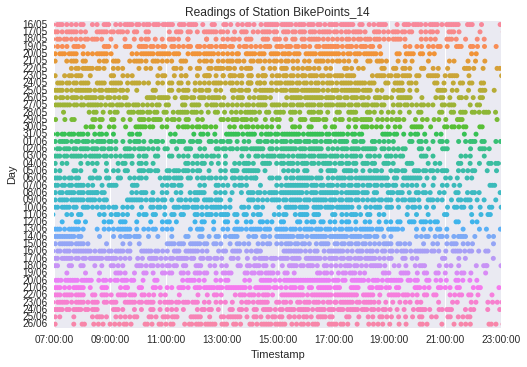

In [19]:
station_id = 'BikePoints_14'
plot_timeline(readings, station_id, start, end)

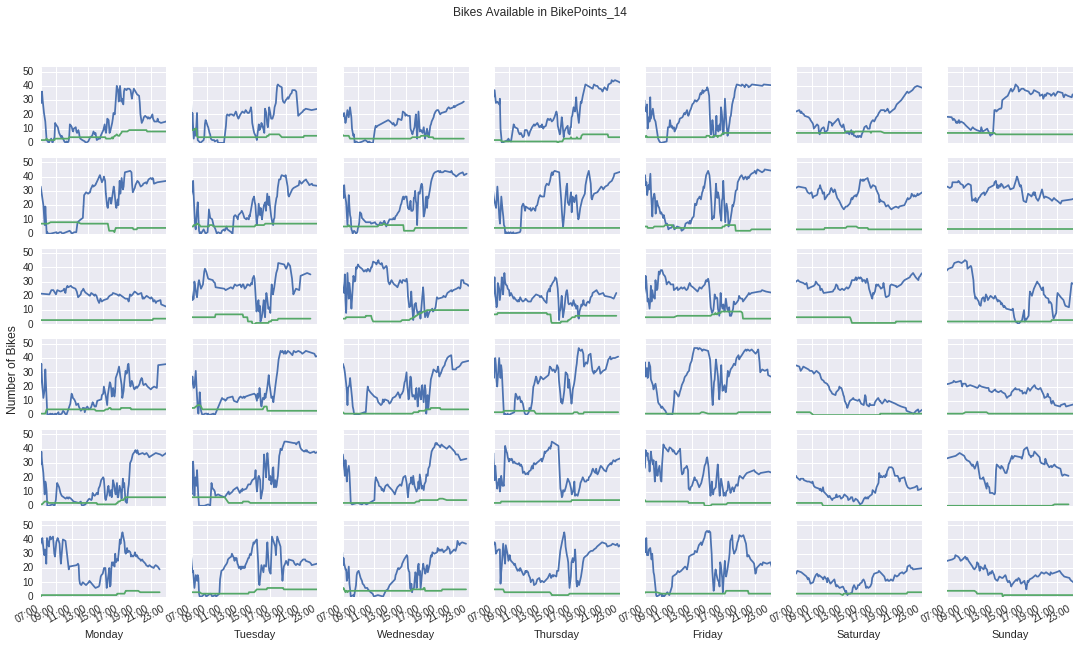

In [20]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)

**Regent's Row , Haggerston ** Outside City Center

In [21]:
station_id = 'BikePoints_553'

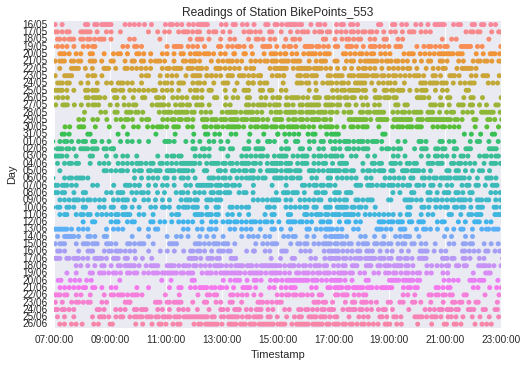

In [22]:
plot_timeline(readings, station_id, start, end)

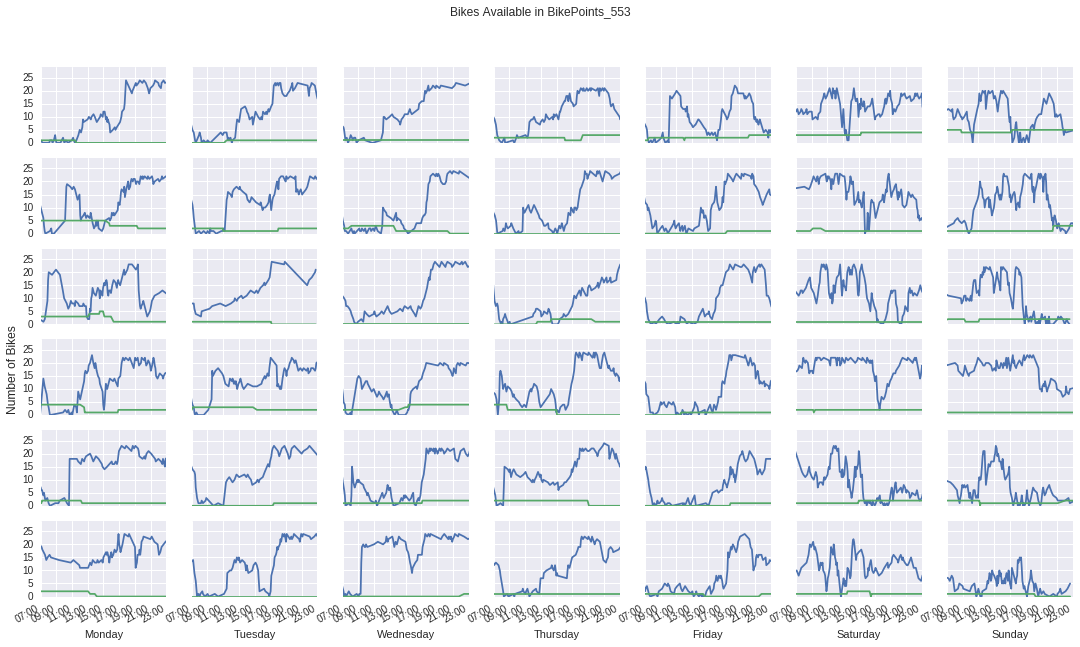

In [23]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)

### Low Priority Stations
**Sackville Street, Mayfair** City Center

In [24]:
station_id = 'BikePoints_318'

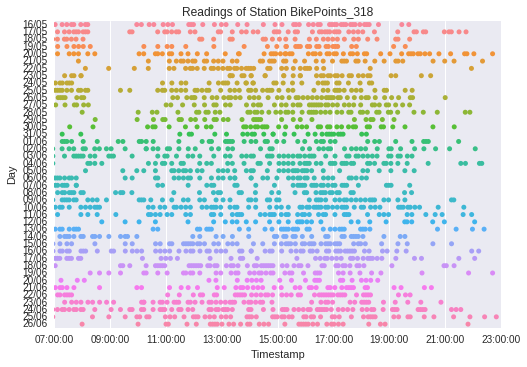

In [25]:
plot_timeline(readings, station_id, start, end)

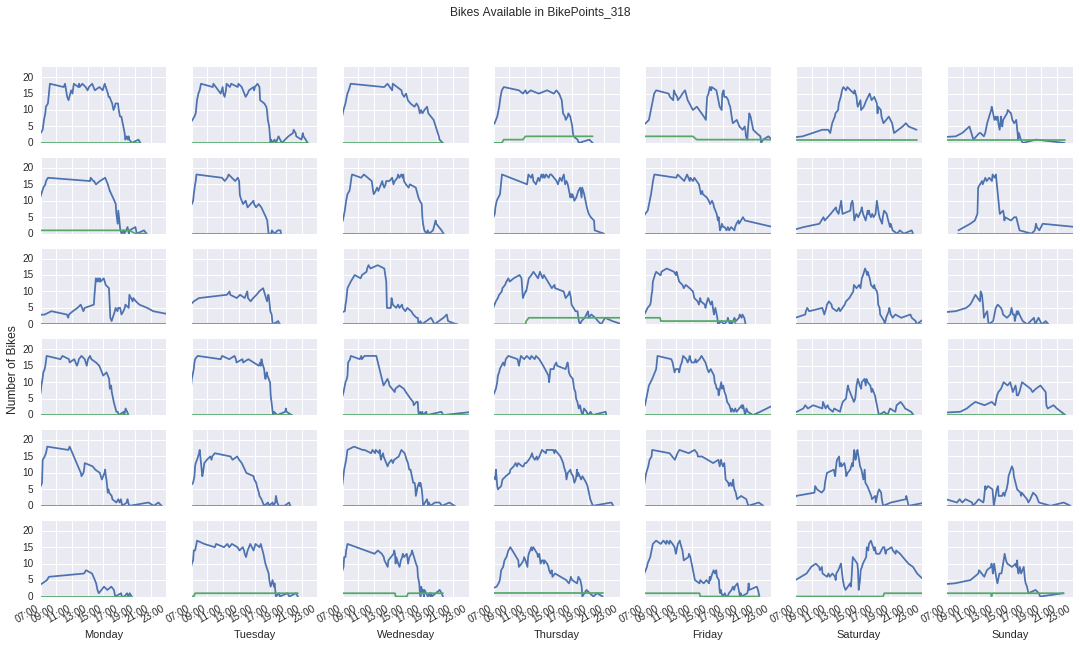

In [26]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)

**St. Mark's Road, North Kensington** Outside City Center

In [27]:
station_id = 'BikePoints_650'

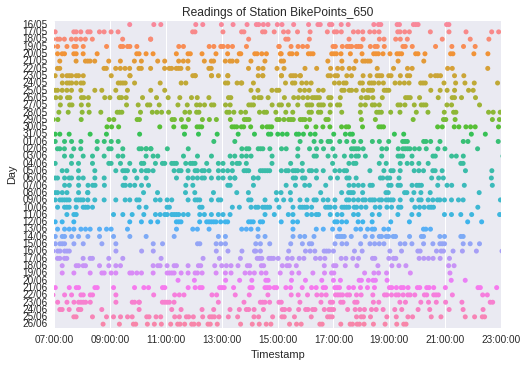

In [28]:
plot_timeline(readings, station_id, start, end)

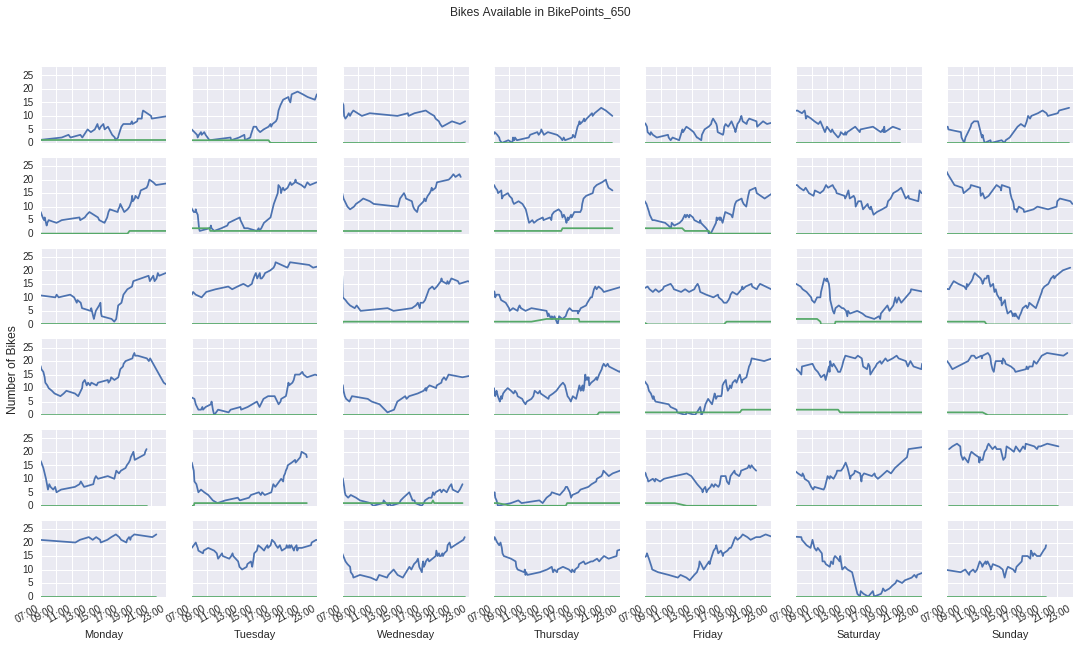

In [29]:
plot_station_readings(readings, station_id, ycols1, ycols2, start, end)

In [30]:
stations.sort_values(by=['Name']).to_csv('stations.csv')

## Bicycle Redistribution

In [31]:
# merge with the stations dataset
stations_redistribution = stations.merge(distributed.groupby('Id').sum(), left_on='Id', how='left', right_index=True)
stations_redistribution.rename(columns = {'NbBikes':'NbBikesDist'}, inplace = True)
stations_redistribution = stations_redistribution.merge(collected.groupby('Id').sum(), left_on='Id', how='left', right_index=True)
stations_redistribution.rename(columns = {'NbBikes':'NbBikesColl'}, inplace = True)
stations_redistribution.drop(['TerminalName','PlaceType','Installed','Temporary','Locked','RemovalDate','InstallDate','ShortName'], axis=1, inplace=True)

# fill missing values with 0
stations_redistribution['NbBikesDist'].fillna(0, inplace=True)
stations_redistribution['NbBikesColl'].fillna(0, inplace=True)

# scale to use easily the colormap
min_max_scaler = preprocessing.MinMaxScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
stations_redistribution['NbBikesDistS'] = min_max_scaler.fit_transform(stations_redistribution['NbBikesDist'].values.reshape(-1, 1))
stations_redistribution['NbBikesCollS'] = min_max_scaler.fit_transform(stations_redistribution['NbBikesColl'].values.reshape(-1, 1))

In [32]:
def cmap_to_hex(cmap, value):
    rgb = cmap(value)[:3]
    return clrs.rgb2hex(rgb)

def create_redistribution_marker(col_name):
    def create_marker(station):
        line_color = map_priority_color(station['Priority'])[1]
        fill_color = cmap_to_hex(Oranges_9.mpl_colormap, station[col_name])
    
        label = "%s - %s" % (station['Id'], station['Name'])

        return folium.CircleMarker(location=[station['Latitude'], station['Longitude']], radius=100,
                        popup=label, color=line_color, fill_color=fill_color, fill_opacity=0.9)
    
    return create_marker

In [33]:
def plot_redistribution_grid(df, start, end, ids=None):
    df = df[df['Id'].isin(ids)]
    df = filter_by_time(df, start, end).copy()
    df['Day'] = df['Timestamp'].apply(lambda x: x.strftime("%d/%m"))
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=1970, month=1, day=1))
    
    day_start, day_end = get_day_start_end(df.iloc[0]['Timestamp'])
    g = sns.FacetGrid(df, col="Id", col_wrap=4, size=3, xlim=(day_start, day_end), sharex=True, sharey=True, col_order=ids)
    [ax.xaxis_date() for ax in g.axes]
    [ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M")) for ax in g.axes]
    g = g.map(sns.stripplot, "Timestamp", "Day", "Day", orient='h', palette="hls")
    g = g.set(xticks=pd.date_range(start=day_start,end=day_end, freq='6h'))
    
    return g

### Distributed

In [34]:
top_distributed = stations_redistribution.sort_values(by=['NbBikesDist'], ascending=False)[0:20]
top_distributed

,Id,Name,Latitude,Longitude,Priority,NbBikesDist,NbBikesColl,NbBikesDistS,NbBikesCollS
293,BikePoints_374,"Waterloo Station 1, Waterloo",51.504027,-0.113864,1,8294.0,5972.0,1.000000,0.541285
280,BikePoints_361,"Waterloo Station 2, Waterloo",51.503919,-0.113426,1,6768.0,4605.0,0.816012,0.417384
499,BikePoints_574,"Eagle Wharf Road, Hoxton",51.533560,-0.093150,2,3537.0,175.0,0.426453,0.015862
15,BikePoints_112,"Stonecutter Street, Holborn",51.515809,-0.105270,2,3520.0,11033.0,0.424403,1.000000
110,BikePoints_20,"Drummond Street, Euston",51.527736,-0.135273,2,3246.0,1773.0,0.391367,0.160700
61,BikePoints_154,"Waterloo Station 3, Waterloo",51.503791,-0.112824,1,3170.0,1609.0,0.382204,0.145835
591,BikePoints_66,"Holborn Circus, Holborn",51.517950,-0.108657,1,2633.0,2018.0,0.317458,0.182906
469,BikePoints_546,"New Fetter Lane, Holborn",51.517428,-0.107987,2,2205.0,1522.0,0.265855,0.137950
163,BikePoints_25,"Doric Way, Somers Town",51.528833,-0.132250,2,2169.0,1234.0,0.261514,0.111846
647,BikePoints_71,"Newgate Street, St. Pauls",51.515418,-0.098850,1,2111.0,2717.0,0.254521,0.246261


In [35]:
draw_stations_map(top_distributed, create_redistribution_marker('NbBikesDistS'))

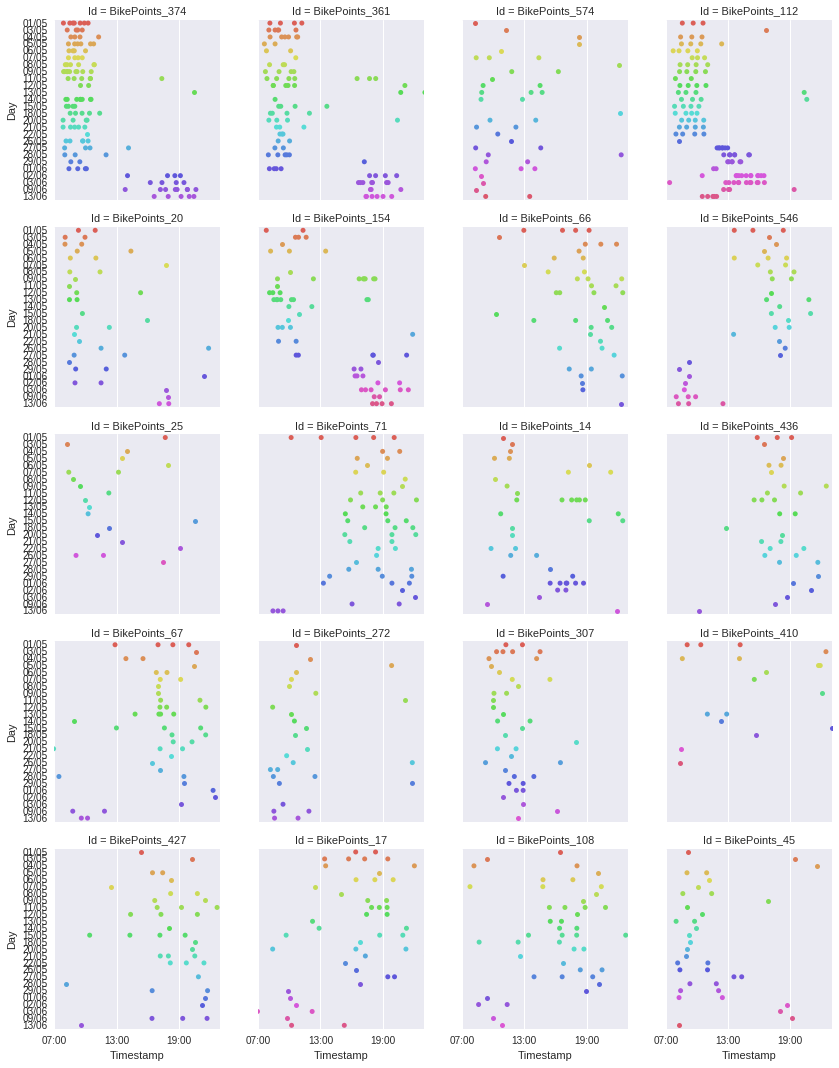

In [36]:
plot_redistribution_grid(distributed, datetime(2015,5,1), datetime(2015,6,30), ids=top_distributed['Id'])

### Collected

In [37]:
top_collected = stations_redistribution.sort_values(by=['NbBikesColl'], ascending=False)[0:20]
top_collected

,Id,Name,Latitude,Longitude,Priority,NbBikesDist,NbBikesColl,NbBikesDistS,NbBikesCollS
15,BikePoints_112,"Stonecutter Street, Holborn",51.515809,-0.105270,2,3520.0,11033.0,0.424403,1.000000
293,BikePoints_374,"Waterloo Station 1, Waterloo",51.504027,-0.113864,1,8294.0,5972.0,1.000000,0.541285
104,BikePoints_194,"Hop Exchange, The Borough",51.504627,-0.091773,1,454.0,5059.0,0.054738,0.458533
280,BikePoints_361,"Waterloo Station 2, Waterloo",51.503919,-0.113426,1,6768.0,4605.0,0.816012,0.417384
140,BikePoints_228,"St. Jamess Square, St. Jamess",51.507424,-0.134621,1,707.0,3032.0,0.085242,0.274812
647,BikePoints_71,"Newgate Street, St. Pauls",51.515418,-0.098850,1,2111.0,2717.0,0.254521,0.246261
503,BikePoints_579,"Queen Street 2, Bank",51.511246,-0.093051,1,1359.0,2655.0,0.163853,0.240642
165,BikePoints_251,"Brushfield Street, Liverpool Street",51.518908,-0.079249,1,798.0,2434.0,0.096214,0.220611
10,BikePoints_108,"Abbey Orchard Street, Westminster",51.498125,-0.132102,1,1707.0,2352.0,0.205811,0.213179
103,BikePoints_193,"Bankside Mix, Bankside",51.505817,-0.100186,1,435.0,2251.0,0.052448,0.204024


In [38]:
draw_stations_map(top_collected, create_redistribution_marker('NbBikesCollS'))

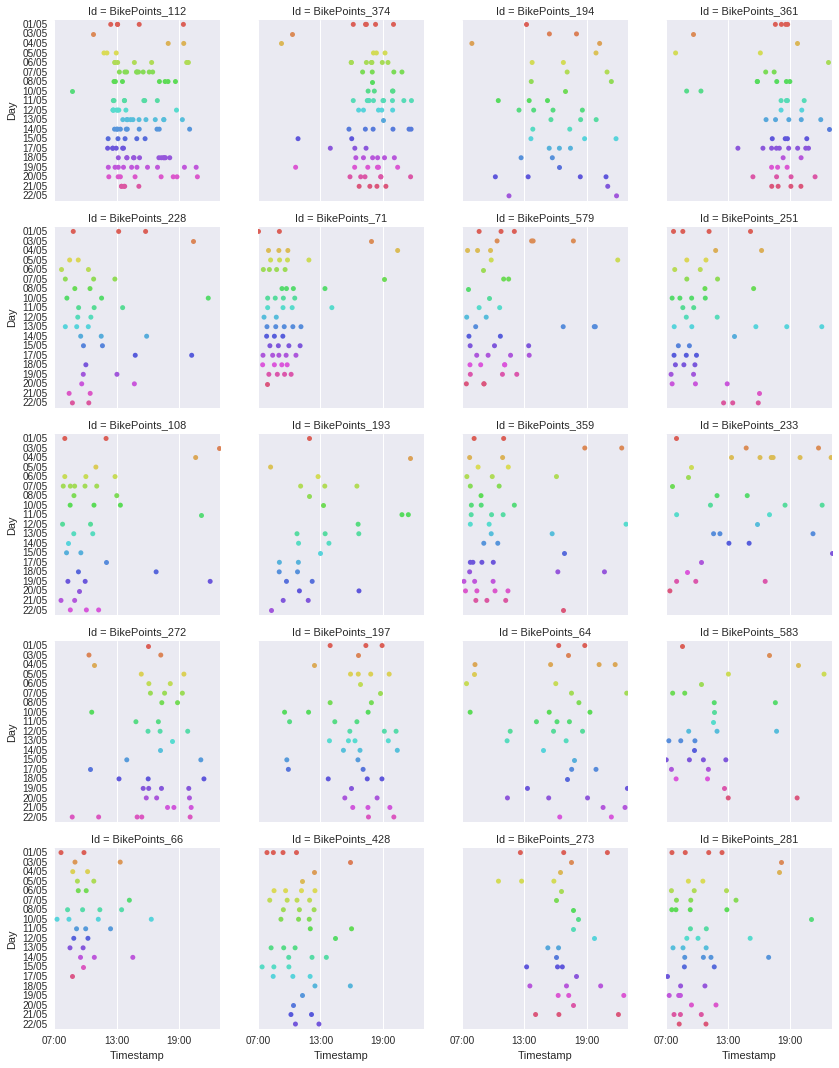

In [39]:
plot_redistribution_grid(collected, datetime(2015,5,1), datetime(2015,6,30), ids=top_collected['Id'])